In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
import time
from sympy.solvers.diophantine import power_representation
import itertools

In [3]:
def binomial(n,k):
    return factorial(n)/(factorial(k)*factorial(n-k))

def multinomial(lst,n):
    m = factorial(n)
    for i in lst:
        m *= 1/factorial(i)
    return m

In [4]:
# Dados dos numeros n,m lst retorna todas las tuplas que son soluciones de enteros no negativas a la ecuación
# r1 + r2 + ... + rm = n
def lst(n,m):
    eq_sols = list(power_representation(n,1,m, zeros=True)) # soluciones enteras no negativas de la ecuación.
    
    sols_permutations = [] # Permutaciones de la solución. 
    
    for sol in eq_sols:
        sols_permutations.append(list(itertools.permutations(sol))) 
        
    sols_permutations = list(set().union(*sols_permutations)) # Eliminamos elementos repetidos
    
    return sols_permutations

### Para darse una idea de lo que hace lst, corra la siguiente casilla dandole valores a n y a m

In [5]:
lst(2,3)

[(0, 2, 0), (0, 1, 1), (1, 1, 0), (0, 0, 2), (1, 0, 1), (2, 0, 0)]

In [5]:
# Autodescriptiva
def plot_figures(Us,Ss,Ws):
    fig1,ax1 = plt.subplots()
    ax1.plot(Us,Ws,'o',label = 'W vs U')
    ax1.set_xlabel('U')
    ax1.set_ylabel('W')
    ax1.legend()
    plt.show()
    fig1,ax1 = plt.subplots()
    ax1.plot(Us,Ss,'o',label = 'S vs U')
    ax1.set_xlabel('U')
    ax1.set_ylabel('S')
    ax1.legend()
    plt.show()

### Simulación

### Idea para contar microestados:
se tiene el vector Num_sol y el vector Us con las energias posibles del sistema , ordenado. W será el vector cuyo elemento_i es el numero de microestados compatibles con la energia Us_i

W = []

Para energia en Us:
    
    W_e = 0

    Para estado en Num_sol:
    
        Si energia_del_estado = energia :
        
            W_e += calcular_degeneracion(estado)
            
            Num_sol.Borrar(estado)
     
     W.agregar(W_e)
            
Lo de borrar estado se hace para que se agilice la ejecucion con el paso de las iteraciones


Más aun, el codigo se ha hecho con un parametro index_ratio, para que el ciclo de arriba empiece por las energias
que poseen mayor numero de microestados, de esta forma el codigo es más eficiente.
Por esta razón, si va a correr el codigo para n grandes, hagalo primero para n pequeños 
y viendo la grafica estime dicho index_ratio ( que depende del espectro). Por ejemplo, si el espectro es equiespaciado,
entonces ponga index_ratio = 0.5
Aun asi, para numeros muy grandes, puede tardar minutos, sin mbargo, puede notar que con numeros pequeños se pueden hacer graficas que se parecen a las que salen con numeros grandes, lucen similares pero escaladas.

In [6]:
#Dada una lista, la ordena de menor a mayor y elimina las redundancias    
def Simplify_Us(Us):
    Us.sort()
    min_energy = Us[0]
    U_new = [min_energy]
    for energy in Us:
        if(energy>min_energy):
            min_energy = energy
            U_new.append(energy)
    return U_new

#Obtiene vector de posibles enerias del sistema
def get_Us(Num_sol,E_spectrum):
    Us = []
    for sol in Num_sol:
        energy = np.dot(E_spectrum,sol)
        Us.append(energy)
    return Simplify_Us(Us)



#Dada una energia U, numero de particulas n, Espetro E_spctrm y arreglo con TODOS los estados de ocupación Num_sol
# retorna la degenarión de U ( W) y la entropia S 
def get_thermo_var(U,n,E_spctrm,Num_sol):
    W = 0
    total_micros = len(Num_sol)
    micro = 0
    for iteration in range(total_micros):
        Energy = np.dot(Num_sol[micro],E_spctrm)
        if(Energy == U):
            W += multinomial(Num_sol[micro],n)
            del Num_sol[micro]
            micro -= 1
        micro += 1
    if(W != 0):
        S = np.log(W)
    else:
        S = -1
    return W,S

#Dado un n ( numero de particulas), y un espectro de enrgia asociado E_spctrm, 
#retorna los vectores degeneración Ws, entropia Ss y energia Us
#Si la bandera flag se ha activado (True), imprimer numeros cada vez que hay una iteración, que deben ir desde 0 hasta len energia
#Esto para que se de una idea del tiempo que falta para acabar la ejecución, tenga en cuenta que el algotimo está hecho
# de tal forma que intenta ser más rapido con el paso de las iteraciones

def simulate(n,E_spctrm,index_ratio,flag = False):
    Num_solutions = lst(n,len(E_spctrm))
    Us = get_Us(Num_solutions, E_spctrm)
    len_U = len(Us)
    Ss = [0]*len_U
    Ws = [0]*len_U
    print('len energia\t',len(Us))
    maximum_index = int(index_ratio*len_U-1)
    index_list = re_organize_index(len_U,maximum_index)
    i = 0
    for index in index_list:
        energy = Us[index]
        W,S = get_thermo_var(energy,n,E_spctrm,Num_solutions)
        Ws[index] = W
        Ss[index] = S
        if(flag):
            print('Iteración #:\t',i,' de\t',len_U)
            i += 1
    return Ws,Ss,Us

def simulate_and_plot(n,E_spctrm,index_ratio = 0.5,flag = False):
    m = len(E_spctrm)
    Num_sol = lst(n,m)
    Ws,Ss,Us = simulate(n,E_spctrm,index_ratio,flag)
    plot_figures(Us,Ss,Ws)
    return Ws,Ss,Us

In [7]:
def re_organize_index(L,maxi):
    Up = []
    Up.append(maxi)
    for i in range(1,maxi+1):
        if((maxi+i) < L):
            Up.append(maxi+i)
        Up.append(maxi-i)
    if(2*maxi <L):
        for i in range(2*maxi+1,L):
            Up.append(i)
    return Up

In [15]:
# Especificar parametros
n = 10 #numero de particulas
E_spectrum = np.linspace(1,6,6)
m = len(E_spectrum)
print('Numero total de soluciones como tuplas:\t',binomial(n+m-1,m-1))

Numero total de soluciones como tuplas:	 3003.0


C:\isaac\anaconda1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


len energia	 101
Iteración #:	 0  de	 101
Iteración #:	 1  de	 101
Iteración #:	 2  de	 101
Iteración #:	 3  de	 101
Iteración #:	 4  de	 101
Iteración #:	 5  de	 101
Iteración #:	 6  de	 101
Iteración #:	 7  de	 101
Iteración #:	 8  de	 101
Iteración #:	 9  de	 101
Iteración #:	 10  de	 101
Iteración #:	 11  de	 101
Iteración #:	 12  de	 101
Iteración #:	 13  de	 101
Iteración #:	 14  de	 101
Iteración #:	 15  de	 101
Iteración #:	 16  de	 101
Iteración #:	 17  de	 101
Iteración #:	 18  de	 101
Iteración #:	 19  de	 101
Iteración #:	 20  de	 101
Iteración #:	 21  de	 101
Iteración #:	 22  de	 101
Iteración #:	 23  de	 101
Iteración #:	 24  de	 101
Iteración #:	 25  de	 101
Iteración #:	 26  de	 101
Iteración #:	 27  de	 101
Iteración #:	 28  de	 101
Iteración #:	 29  de	 101
Iteración #:	 30  de	 101
Iteración #:	 31  de	 101
Iteración #:	 32  de	 101
Iteración #:	 33  de	 101
Iteración #:	 34  de	 101
Iteración #:	 35  de	 101
Iteración #:	 36  de	 101
Iteración #:	 37  de	 101
Itera

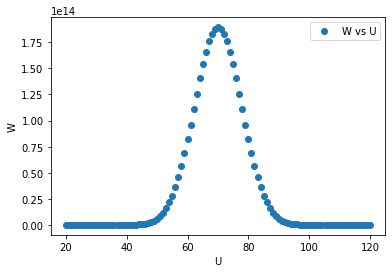

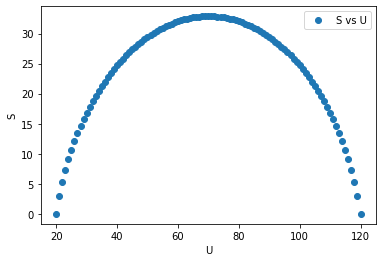

Tiempo:	 7.706790099999921


C:\isaac\anaconda1\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [13]:
#Simular,
tic = time.clock()
Ws,Ss,Us = simulate_and_plot(20,E_spectrum,0.5,True)
toc = time.clock()
print('Tiempo:\t',toc-tic)

C:\isaac\anaconda1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


len energia	 101
Iteración #:	 0  de	 101
Iteración #:	 1  de	 101
Iteración #:	 2  de	 101
Iteración #:	 3  de	 101
Iteración #:	 4  de	 101
Iteración #:	 5  de	 101
Iteración #:	 6  de	 101
Iteración #:	 7  de	 101
Iteración #:	 8  de	 101
Iteración #:	 9  de	 101
Iteración #:	 10  de	 101
Iteración #:	 11  de	 101
Iteración #:	 12  de	 101
Iteración #:	 13  de	 101
Iteración #:	 14  de	 101
Iteración #:	 15  de	 101
Iteración #:	 16  de	 101
Iteración #:	 17  de	 101
Iteración #:	 18  de	 101
Iteración #:	 19  de	 101
Iteración #:	 20  de	 101
Iteración #:	 21  de	 101
Iteración #:	 22  de	 101
Iteración #:	 23  de	 101
Iteración #:	 24  de	 101
Iteración #:	 25  de	 101
Iteración #:	 26  de	 101
Iteración #:	 27  de	 101
Iteración #:	 28  de	 101
Iteración #:	 29  de	 101
Iteración #:	 30  de	 101
Iteración #:	 31  de	 101
Iteración #:	 32  de	 101
Iteración #:	 33  de	 101
Iteración #:	 34  de	 101
Iteración #:	 35  de	 101
Iteración #:	 36  de	 101
Iteración #:	 37  de	 101
Itera

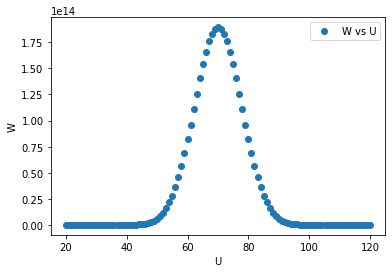

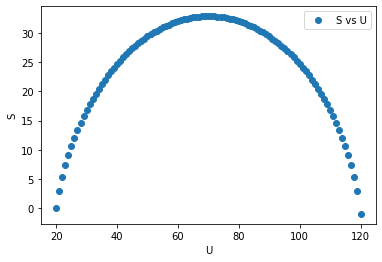

Tiempo:	 16.047448499999973


C:\isaac\anaconda1\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [14]:
#misma simulacion de arriba, pero con un index_ratio de 0, osea empezando a contar desde la enrgia más baja.
#Simular,
tic = time.clock()
Ws,Ss,Us = simulate_and_plot(20,E_spectrum,0,True)
toc = time.clock()
print('Tiempo:\t',toc-tic)